In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

data = pd.read_csv("DATA.csv")
data.head()

data["Y30"] = data["WYNN"].shift(-30)
data

X = np.array(data[["WYNN","MGM", "LVS", "PENN", "UNEM", "CPI", "GDPCAP", "INT", "RATE", "PASS"]].iloc[:-1000])
y = np.array(data[["Y30"]].iloc[:-1000])

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=0, verbose=2, max_features=3, bootstrap = True)
rf.fit(X_train, y_train)

# evaluate the model
score = rf.score(X_test, y_test)
print("R^2 score: {:.2f}".format(score))

results = []
for val in X:
    results.append(rf.predict(np.array(val).reshape(1, -1)))

data["Results"] = pd.DataFrame(results)
data

predictions = []
for val in np.array(data[["WYNN","MGM", "LVS", "PENN", "UNEM", "CPI", "GDPCAP", "INT", "RATE", "PASS"]].iloc[-1000:]):
    predictions.append(rf.predict(np.array(val).reshape(1, -1)))
data["Predictions"] = pd.DataFrame(predictions)
data["Predictions"] = data["Predictions"].shift(3403)

fig, ax = plt.subplots(figsize=(40,20))
data[["WYNN"]].plot.line(ax=ax)
data[["Results"]].plot.line(ax=ax)
data[["Predictions"]].plot.line(ax=ax)

### Significant overfitting (I am using the structure that the paper used so I will probs tweak it)

data

# Now w/ Log Diff

log_diff_df = np.log(data[["MGM","LVS","PENN","WYNN"]])
log_diff_df

log_diff_df = log_diff_df.diff()
log_diff_df[["UNEM", "CPI", "GDPCAP", "INT", "RATE", "PASS"]] = data[["UNEM", "CPI", "GDPCAP", "INT", "RATE", "PASS"]].diff(30)
log_diff_df

log_diff_df.hist(bins=50)

In [2]:
start = datetime.datetime(2004, 9, 1)
end = datetime.datetime.today()
var_list = ["UNRATE", "CPALTT01USM657N", "A939RX0Q048SBEA", "REAINTRATREARAT10Y", "MORTGAGE30US", "AIRRPMTSID11"]
var_df = pd.DataFrame()
for var in var_list:
    var_data = web.DataReader(var, "fred", start, end)
    var_data = var_data.diff().resample("1D").ffill()
    var_df[[var]] = var_data
var_df.rename( columns = {"UNRATE":"UNRATE", "CPALTT01USM657N":"CPI", "A939RX0Q048SBEA":"RGDPCAP", "REAINTRATREARAT10Y":"REALINT", "MORTGAGE30US":"MORT", "AIRRPMTSID11":"AIRPASS"}, inplace = True)
var_df

,UNRATE,CPI,RGDPCAP,REALINT,MORT,AIRPASS
DATE,,,,,,
2004-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-02,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-03,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-04,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-01-28,-0.1,NaN,NaN,0.206974,-0.02,NaN
2023-01-29,-0.1,NaN,NaN,0.206974,-0.02,NaN
2023-01-30,-0.1,NaN,NaN,0.206974,-0.02,NaN


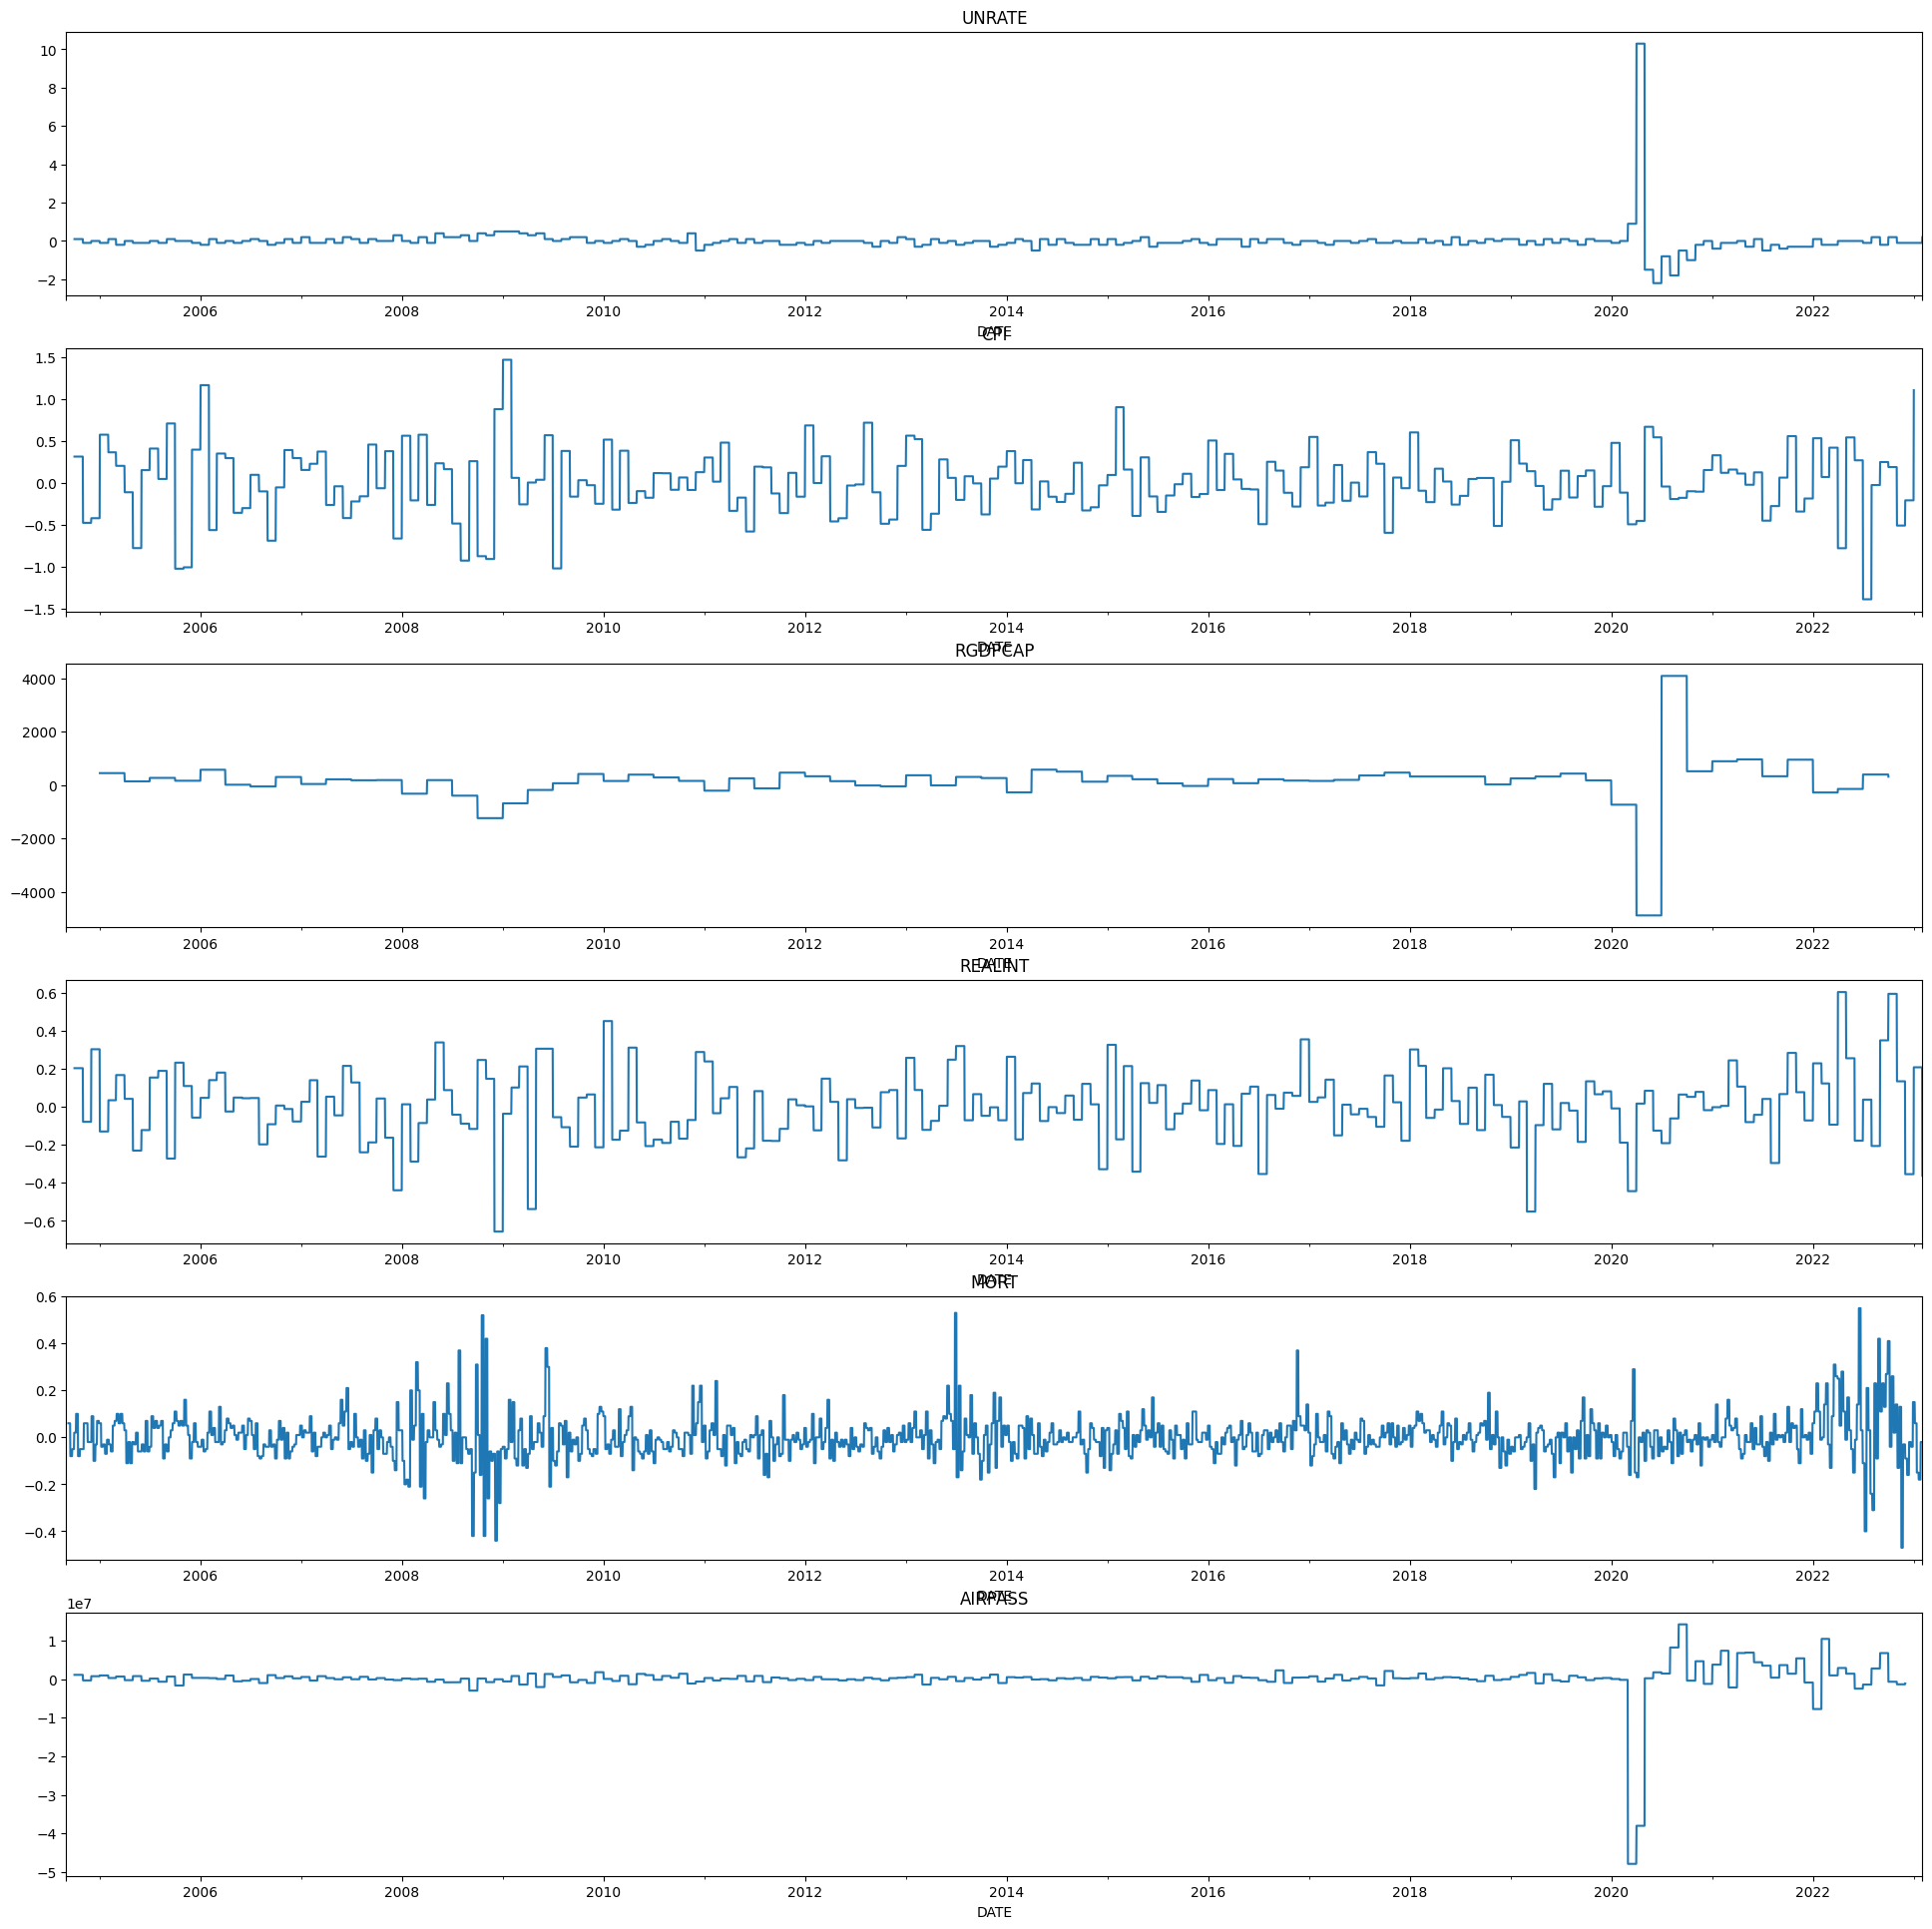

In [3]:
fig, axs = plt.subplots(6, figsize = (24,24))
i = 0
for column in var_df:
    var_df[column].plot.line(ax = axs[i], title = column)
    i = i + 1

In [4]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

stock_list = ["WYNN", "MGM", "LVS", "PENN"]
stock_df = pdr.get_data_yahoo(stock_list, start = start, end = end)["Adj Close"]
stock_df = np.log(stock_df).diff(28)
stock_df

[*********************100%***********************]  4 of 4 completed


,LVS,MGM,PENN,WYNN
Date,,,,
2004-09-01,NaN,NaN,NaN,NaN
2004-09-02,NaN,NaN,NaN,NaN
2004-09-03,NaN,NaN,NaN,NaN
2004-09-07,NaN,NaN,NaN,NaN
2004-09-08,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-03-23,-0.037300,-0.061152,-0.129004,-0.022716
2023-03-24,-0.056688,-0.070662,-0.119092,-0.025017
2023-03-27,-0.059041,-0.056146,-0.126752,-0.025440


array([[<AxesSubplot: title={'center': 'LVS'}>,
        <AxesSubplot: title={'center': 'MGM'}>],
       [<AxesSubplot: title={'center': 'PENN'}>,
        <AxesSubplot: title={'center': 'WYNN'}>]], dtype=object)

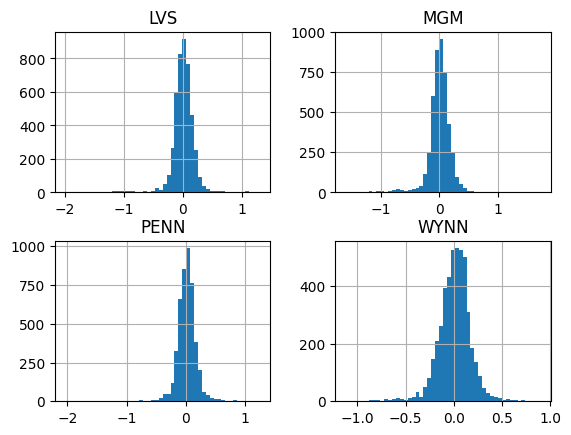

In [5]:
stock_df.hist(bins=50)

In [15]:
stock_df[["UNRATE", "CPI", "RGDPCAP", "REALINT", "MORT", "AIRPASS"]] = var_df
stock_df[["Y30"]] = stock_df[["WYNN"]].shift(28)
stock_df

,LVS,MGM,PENN,WYNN,UNRATE,CPI,RGDPCAP,REALINT,MORT,AIRPASS,Y30
Date,,,,,,,,,,,
2004-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,-0.037300,-0.061152,-0.129004,-0.022716,NaN,NaN,NaN,NaN,NaN,NaN,0.275605
2023-03-24,-0.056688,-0.070662,-0.119092,-0.025017,NaN,NaN,NaN,NaN,NaN,NaN,0.244111
2023-03-27,-0.059041,-0.056146,-0.126752,-0.025440,NaN,NaN,NaN,NaN,NaN,NaN,0.182322


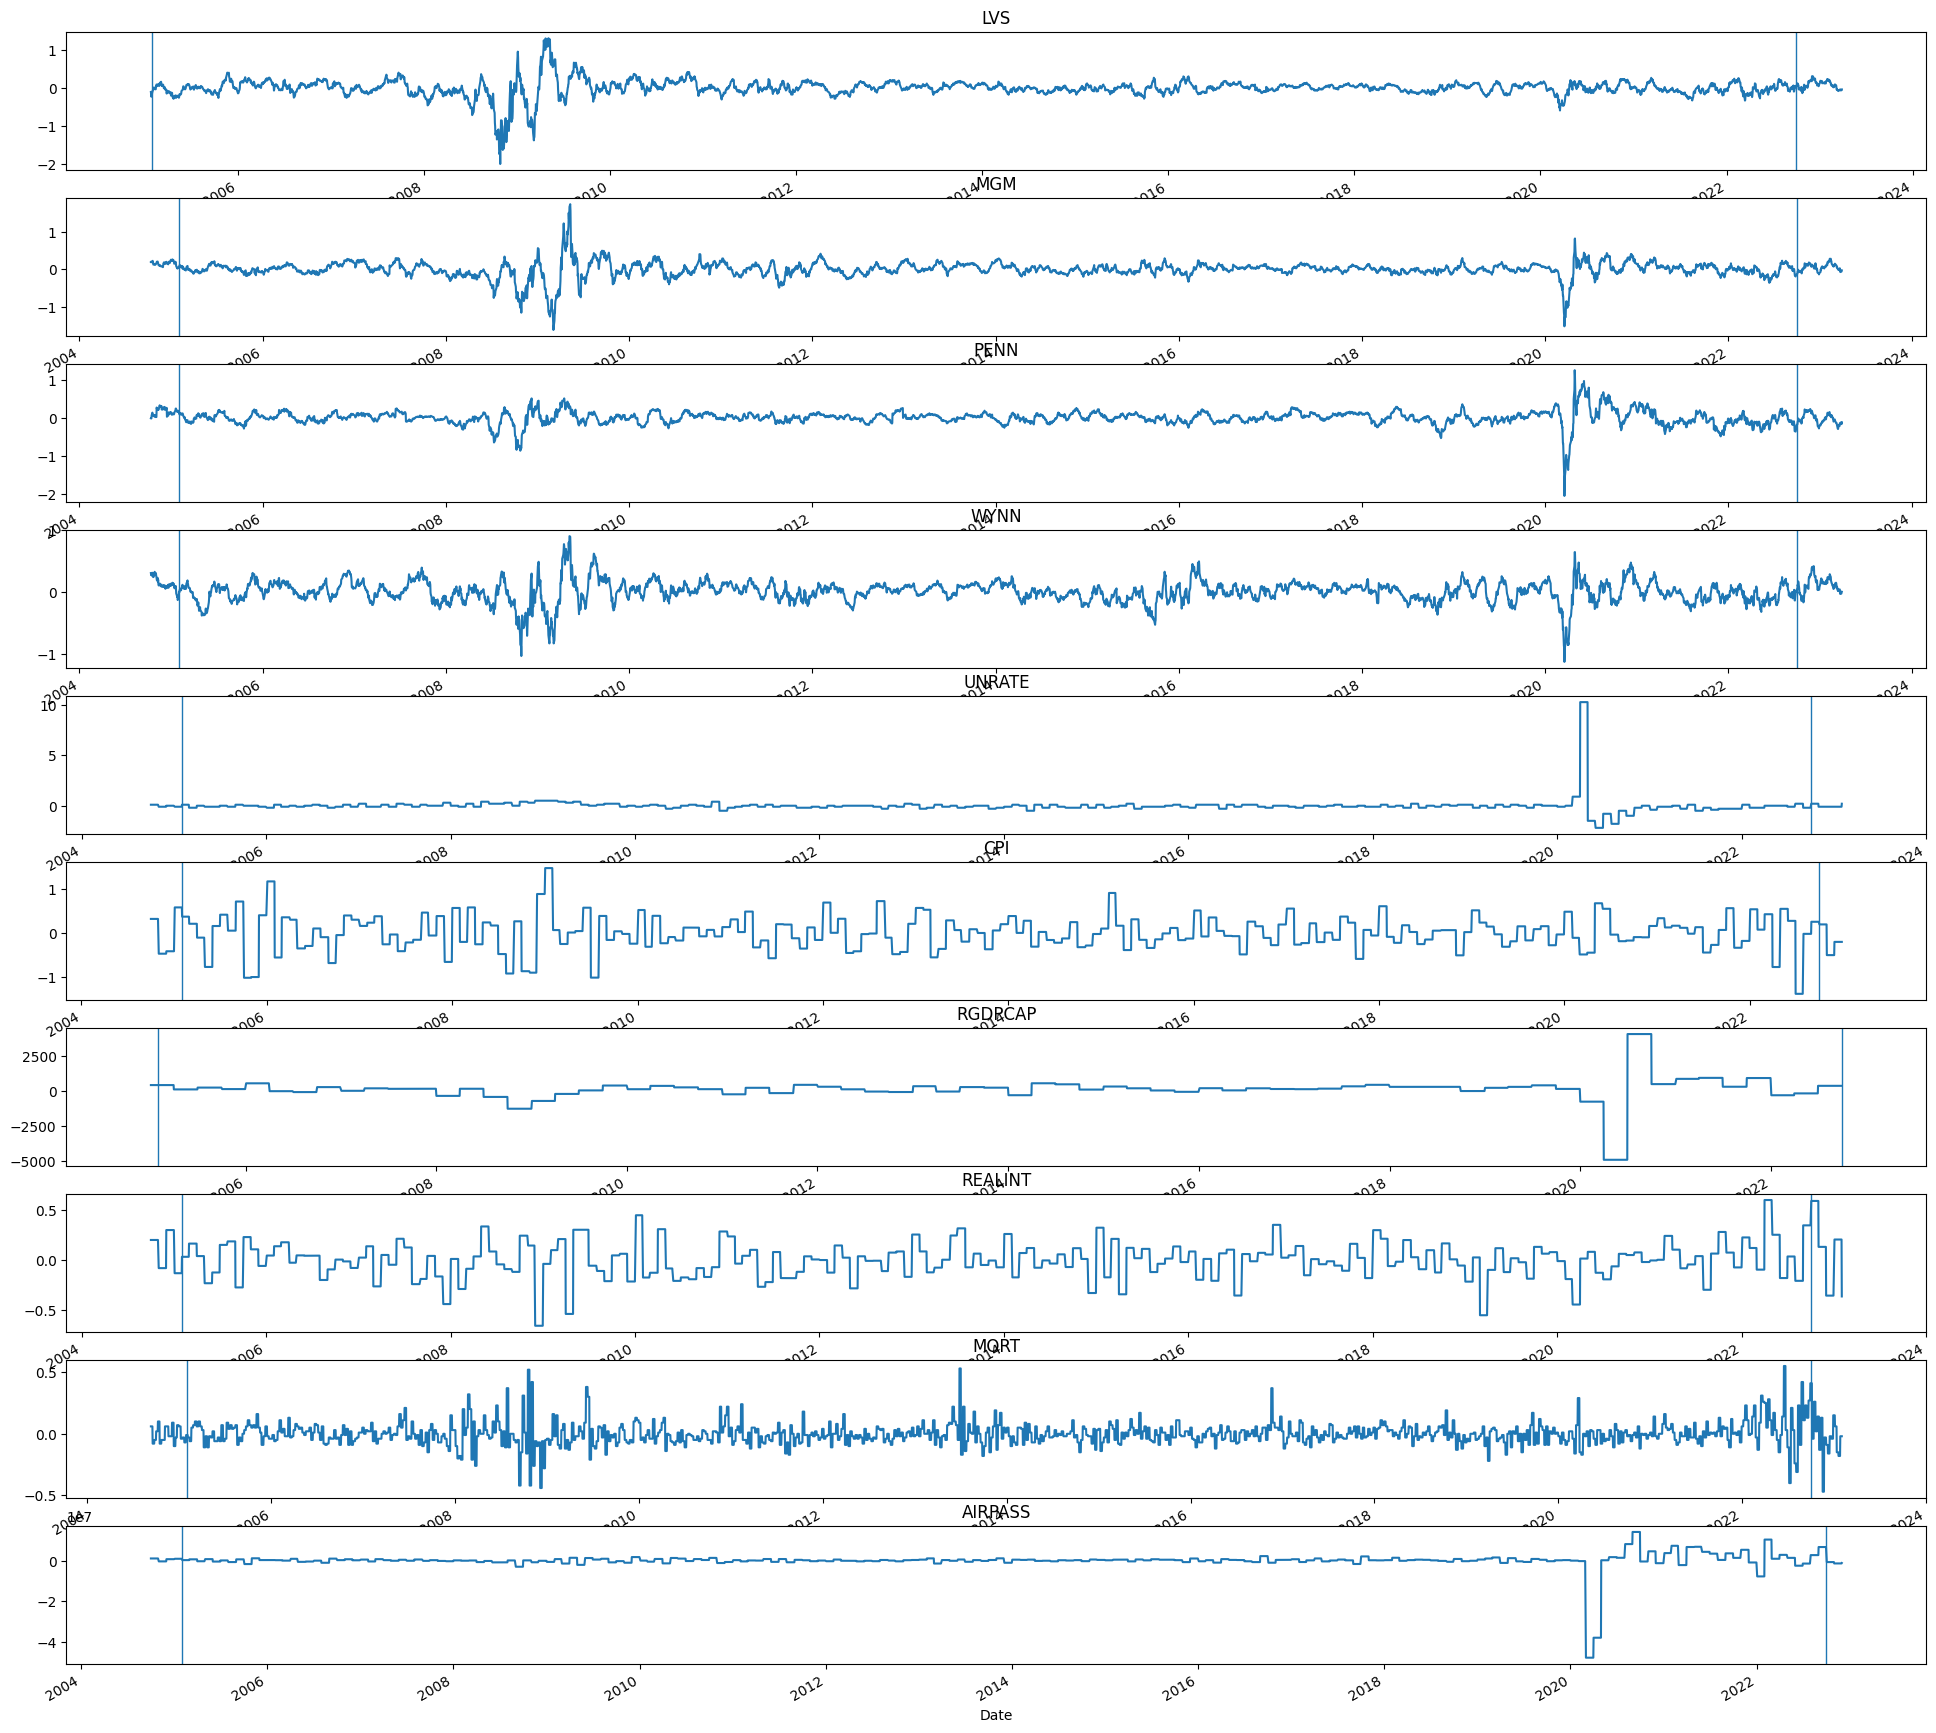

In [12]:
fig, axs = plt.subplots(10, figsize = (24,24))
i = 0
for column in stock_df:
    stock_df[column].plot.line(ax = axs[i], title = column)
    axs[i].axvline("2005-02-01", 
                  linewidth = 1)
    axs[i].axvline('2022-10-01', 
                  linewidth = 1)
    i = i + 1

In [16]:
stock_df[["WYNN", "Y30"]].loc['2010-03-01':'2010-04-15']

,WYNN,Y30
Date,,
2010-03-01,-0.074194,0.096643
2010-03-02,-0.019107,0.073183
2010-03-03,0.015182,0.037246
2010-03-04,0.029885,0.034198
2010-03-05,0.063221,0.025483
2010-03-08,0.093210,-0.015002
2010-03-09,0.105886,0.015576
2010-03-10,0.138698,-0.007580
2010-03-11,0.140156,0.019583


In [19]:
from datetime import timedelta

shifted = pd.Series()
for val in stock_df["WYNN"]:
    print(val, index)

C:\Users\hthog\AppData\Local\Temp\ipykernel_17160\2443934684.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  shifted = pd.Series()


TypeError: cannot unpack non-iterable float object